In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

@author: mperaud
"""

'\n\n@author: mperaud\n'

**Import all necessary modules**

In [2]:

import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.basemap import Basemap
#from geopy.geocoders import Nominatim
#from matplotlib.patches import Polygon
import numpy as np
import os
import csv
import pandas as pd
import datetime
from tabulate import tabulate


**Define maps**

Map creation : EUROPE To define center and four corners of the map GPS coordinates, use  
https://boundingbox.klokantech.com/  
color codes in  
https://web-color.aliasdmc.fr/couleur-web-lightskyblue-rgb-hsl-hexa.html#couleurs-blanc
"small" map excluding Ankara : mg
full Europe map including Ankara : mp
    
https://stackoverflow.airbus.corp/questions/1941 : how share environment with colleagues

In [3]:

mg= Basemap(resolution='l',#low resolution map showing Ankara
            projection='merc',#mercator
            lat_0=44.86, lon_0=9.17,#map center coordinates
            llcrnrlon =-20.38, llcrnrlat =28.97, urcrnrlon = 41.27, urcrnrlat = 59.11)
            #four corners of the map coordinates
mp= Basemap(resolution='l',#low resolution map for western Europe only
            projection='merc',#mercator
            lat_0=48.4407, lon_0=2.4764,#map center coordinates
            llcrnrlon =-11.74, llcrnrlat =34.96, urcrnrlon = 16.73, urcrnrlat = 59.1)
            #four corners of the map coordinates
  

**Read names of line stations, their GPS coordinates, their IATA and ICAO, color code (mg or mp)**  
Stations coordinates in a dataframe 
(Regular = No is for one time stations as Tarbes, Perpignan, Bastia... not useful for this presentation)


In [4]:
location=pd.read_csv('loc.csv',engine='python')
#print(location.head(3))

**Import Skywise data (csv file)**  
Skywise data basis in a panda dataframe. XL+ST flight hours is calculated

In [5]:
DBtemp=pd.read_csv('contour.csv',engine='python')
DBtemp1=DBtemp.assign(ST_XL_flight_hours =DBtemp['ST_flight_time']+DBtemp['XL_flight_time']) #adds a column for total F

**Format dataframe**
 coalesced_timestamp format into date & hour
 

In [6]:

DBtemp1['coalesced_timestamp'] = pd.to_datetime(DBtemp1['coalesced_timestamp']).dt.tz_convert(None)
#print(DBtemp1.head())


**Select data by date**

In [7]:

mask = ( DBtemp1['coalesced_timestamp'] > '2020-01-01 00:00:00') & ( DBtemp1['coalesced_timestamp'] <= '2021-01-01 00:00:00')
DBtemp1=DBtemp1.loc[mask]
#print(DBtemp1.head())

In [8]:
DB_hours_per_programdet=DBtemp1.groupby(["program", "Origin","Dest"], as_index=False)["ST_XL_flight_hours"].sum()
print(DB_hours_per_programdet["ST_XL_flight_hours"].sum())
    
DB_hours_per_program=DBtemp1.groupby(["program"],as_index=False)["ST_XL_flight_hours"].sum()
DB_hours_per_program['Total%']=DB_hours_per_program['ST_XL_flight_hours']/DB_hours_per_program['ST_XL_flight_hours'].sum()

DB_hours_per_program['Total%']=DB_hours_per_program['Total%'].map(lambda n:'{:,.1%}'.format(n))
DB_hours_per_program['ST_XL_flight_hours']=DB_hours_per_program['ST_XL_flight_hours'].map(lambda n:'{:,.0f}'.format(n))



print(tabulate(DB_hours_per_program, headers='keys', tablefmt='fancy_grid'))




5128.1500000000015
╒════╤═══════════╤══════════════════════╤══════════╕
│    │ program   │ ST_XL_flight_hours   │ Total%   │
╞════╪═══════════╪══════════════════════╪══════════╡
│  0 │ LA        │ 21                   │ 0.4%     │
├────┼───────────┼──────────────────────┼──────────┤
│  1 │ LR        │ 421                  │ 8.2%     │
├────┼───────────┼──────────────────────┼──────────┤
│  2 │ ML        │ 142                  │ 2.8%     │
├────┼───────────┼──────────────────────┼──────────┤
│  3 │ SA        │ 2,156                │ 42.0%    │
├────┼───────────┼──────────────────────┼──────────┤
│  4 │ Training  │ 35                   │ 0.7%     │
├────┼───────────┼──────────────────────┼──────────┤
│  5 │ XWB       │ 2,186                │ 42.6%    │
├────┼───────────┼──────────────────────┼──────────┤
│  6 │ empty     │ 168                  │ 3.3%     │
╘════╧═══════════╧══════════════════════╧══════════╛


**Databasis of total hours by program, origin, destination**

In [9]:
DBprov=DB_hours_per_programdet.merge(location, left_on='Origin', right_on='IATA', how='outer')
print(DBprov.head())



  program Origin Dest  ST_XL_flight_hours Regular IATA    Name  Latitude  \
0      LA    EGT  TLS            0.374123     Yes  EGT  Madrid     40.31   
1      LR    EGT  TLS           10.722405     Yes  EGT  Madrid     40.31   
2      SA    EGT  TLS          108.200482     Yes  EGT  Madrid     40.31   
3      SA    EGT  XFW           59.393418     Yes  EGT  Madrid     40.31   
4     XWB    EGT  CEG          107.666667     Yes  EGT  Madrid     40.31   

   Longitude  ICAO Coloration       RGB  
0      -3.73  LEGT    #00FF55  0 255 85  
1      -3.73  LEGT    #00FF55  0 255 85  
2      -3.73  LEGT    #00FF55  0 255 85  
3      -3.73  LEGT    #00FF55  0 255 85  
4      -3.73  LEGT    #00FF55  0 255 85  


In [10]:
DBtemp=DBprov.merge(location, left_on='Dest', right_on='IATA', how='outer')
DBfinal=DBtemp.sort_values(by = ['program','ST_XL_flight_hours'])
print(DBfinal.head(10))


   program Origin Dest  ST_XL_flight_hours Regular_x IATA_x         Name_x  \
0       LA    EGT  TLS            0.374123       Yes    EGT         Madrid   
73      LA    SNR  BYF            0.504529       Yes    SNR  Saint-Nazaire   
87      LA    TLS  EGT            1.336046       Yes    TLS       Toulouse   
93      LA    TLS  IGS            1.750000       Yes    TLS       Toulouse   
5       LA    IGS  TLS            3.833333       Yes    IGS       Manching   
17      LA    XFW  TLS            5.781414       Yes    XFW   Finkenwerder   
48      LA    TLS  XFW            7.583333       Yes    TLS       Toulouse   
55      LR    BRE  XFW            0.212871       Yes    BRE         Bremen   
12      LR    TLS  TLS            0.248318       Yes    TLS       Toulouse   
32      LR    MRS  TLS            0.772022        No    MRS      Marseille   

    Latitude_x  Longitude_x ICAO_x Coloration_x       RGB_x Regular_y IATA_y  \
0    40.310000    -3.730000   LEGT      #00FF55    0 255 85  

Group data by program in a data frame : number of flight hours per program + number of total flight hours from origin to destination.

**Define a function to place plants names on maps**

In [11]:
def lsnames(carte) :
    for row in location.itertuples():
        if row.Regular=='No' :
            continue
        elif row.Name =='Saint-Nazaire':
            x,y =carte(float(row.Longitude),float(row.Latitude)) 
            plt.annotate(row.Name, xy=(x, y),  xycoords='data',xytext=(-200,-1), textcoords='offset points',color=row.Coloration,fontsize=30)
        else :
            x,y =carte(float(row.Longitude),float(row.Latitude)) 
            plt.annotate(row.Name, xy=(x, y),  xycoords='data',xytext=(1,-1), textcoords='offset points',color=row.Coloration,fontsize=30)
    return






**Function that creates arrow from one point to another one**

In [12]:

def gclineAtoB(lonA,latA,lonB,latB,wid,couleur,A,B,carte):
    gclineAtoB, = carte.drawgreatcircle(lonA,latA,lonB,latB,linewidth=wid,color=couleur)
    path = gclineAtoB.get_path() # get path from the great circle
    
    head = carte(lonB,latB)    # get location of arrow's head (at A) 
    tail = path.vertices[-round(len(path)/6)] # get location of arrow's tail 
    path = gclineAtoB.get_path() # get path from the great circle
    
#draw annotation with arrow in  color 
#blank text is specified, because we need the arrow only 
#adjust facecolor and other arrow properties as needed 
    plt.annotate('', 
    xy=(head[0], head[1]), 
    xycoords='data', 
    xytext=(tail[0], tail[1]), 
    textcoords='data', 
    size=0.1, 
    arrowprops=dict(headwidth=20, 
    headlength=10,  
    facecolor=couleur, 
    edgecolor="none",  
    connectionstyle="arc3, rad=0.001")) 
    
    
    return

**Define function that places arrows and stations on a map for a given program**

In [13]:


#For selected program, print all arrows from one place to the other
def fleches(PROG) :
    if PROG == 'ML':
        mg.fillcontinents(color='#fffaf0',lake_color='#b0C4DE')#fill with colors defined above
        mg.drawcoastlines()
        mg.drawcountries()
    else :
        mp.fillcontinents(color='#fffaf0',lake_color='#b0C4DE')#fill with colors defined above
        mp.drawcoastlines()
        mp.drawcountries()
        
    for ligne in DBfinal.itertuples():
        if ligne.program !=PROG :
            continue
        else :
            if PROG=='ML':
                gclineAtoB(ligne.Longitude_x,ligne.Latitude_x,ligne.Longitude_y,ligne.Latitude_y,
                           round(ligne.ST_XL_flight_hours,1),ligne.Coloration_x,'',ligne.Name_y,mg)
                #print(ligne.Name_x, ligne.Name_y, float(round(ligne.ST_XL_flight_hours/2,1)))
               
                plt.title(PROG,fontsize =50)
                lsnames(mg)
            else :
                gclineAtoB(ligne.Longitude_x,ligne.Latitude_x,ligne.Longitude_y,ligne.Latitude_y,
                           round(ligne.ST_XL_flight_hours/10,1),ligne.Coloration_x,'',ligne.Name_y,mp)
                #print(ligne.Name_x, ligne.Name_y, float(round(ligne.ST_XL_flight_hours,1)))
                plt.title(PROG, fontsize=50)
                lsnames(mp)
    return
     

#plt.text(xxfw,round(yxfw/1.5), "40 FH\n22 jigs",fontsize=15,
#                    ha='left',va='center',color='w',
#                    bbox=dict(facecolor='b', alpha=1))

#plt.text(xxfw,round(xtls/1.5), "40 FH\n22 fuselages",fontsize=15,
#                    ha='left',va='center',color='w',
#                   bbox=dict(facecolor='c', alpha=1))












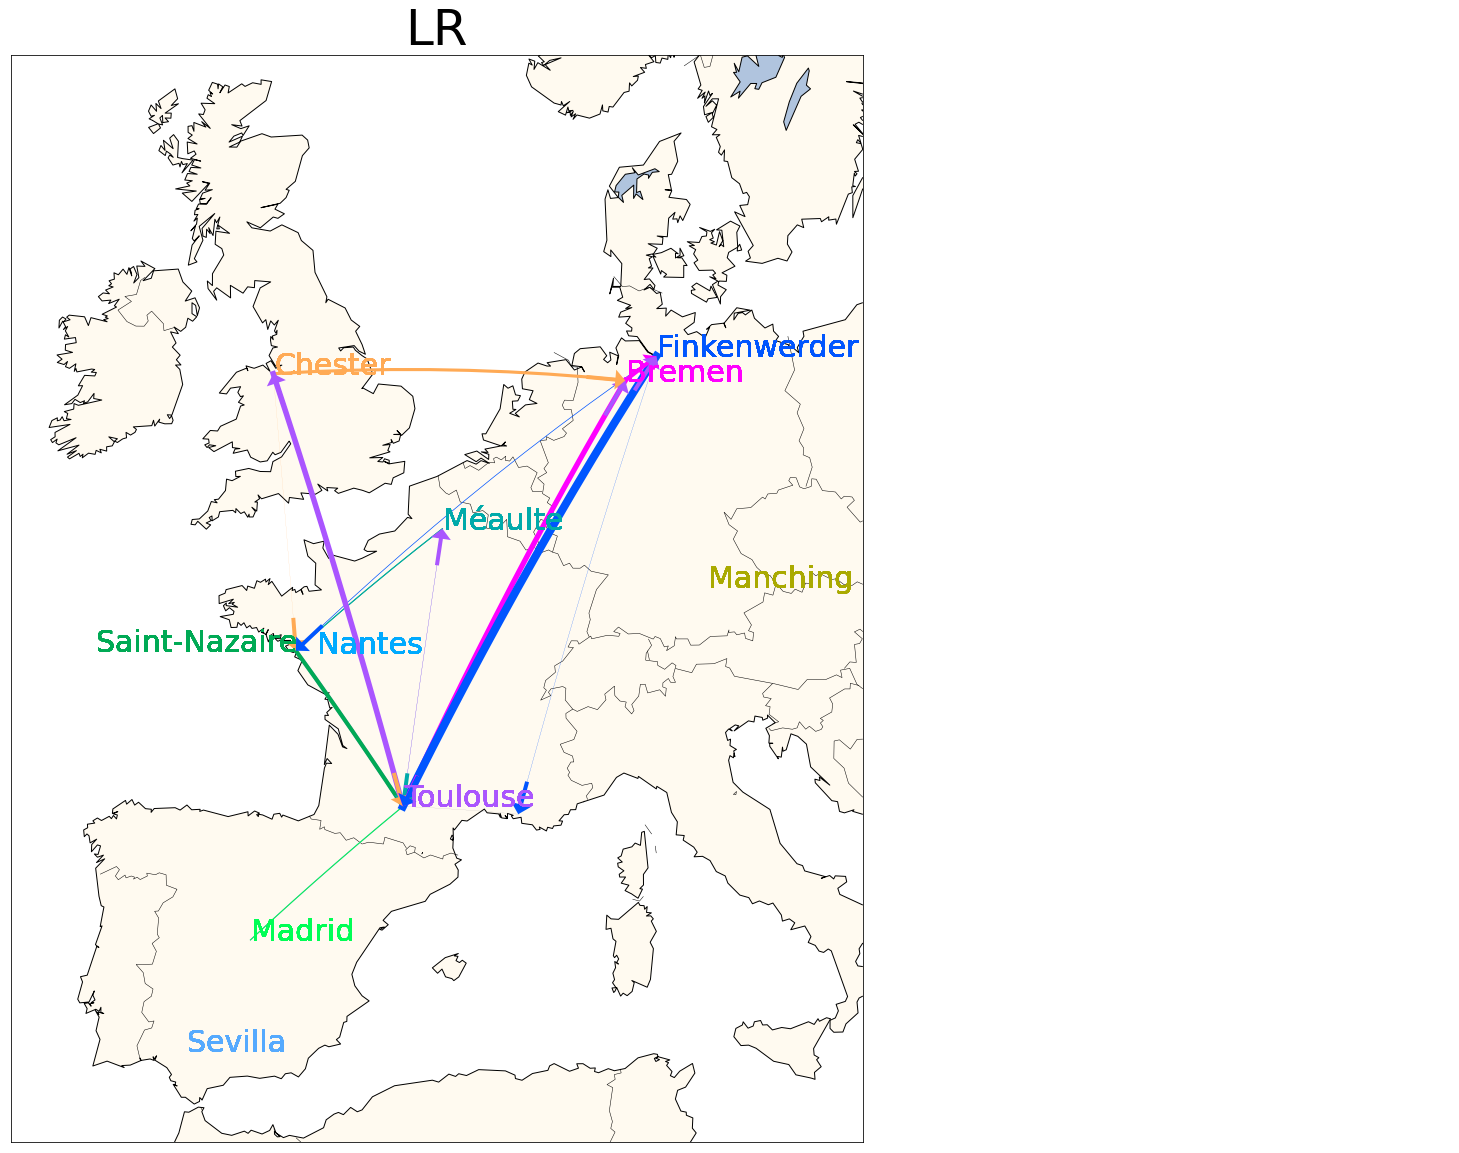

In [14]:
figure =plt.figure(figsize =(20,20))
fleches('LR')


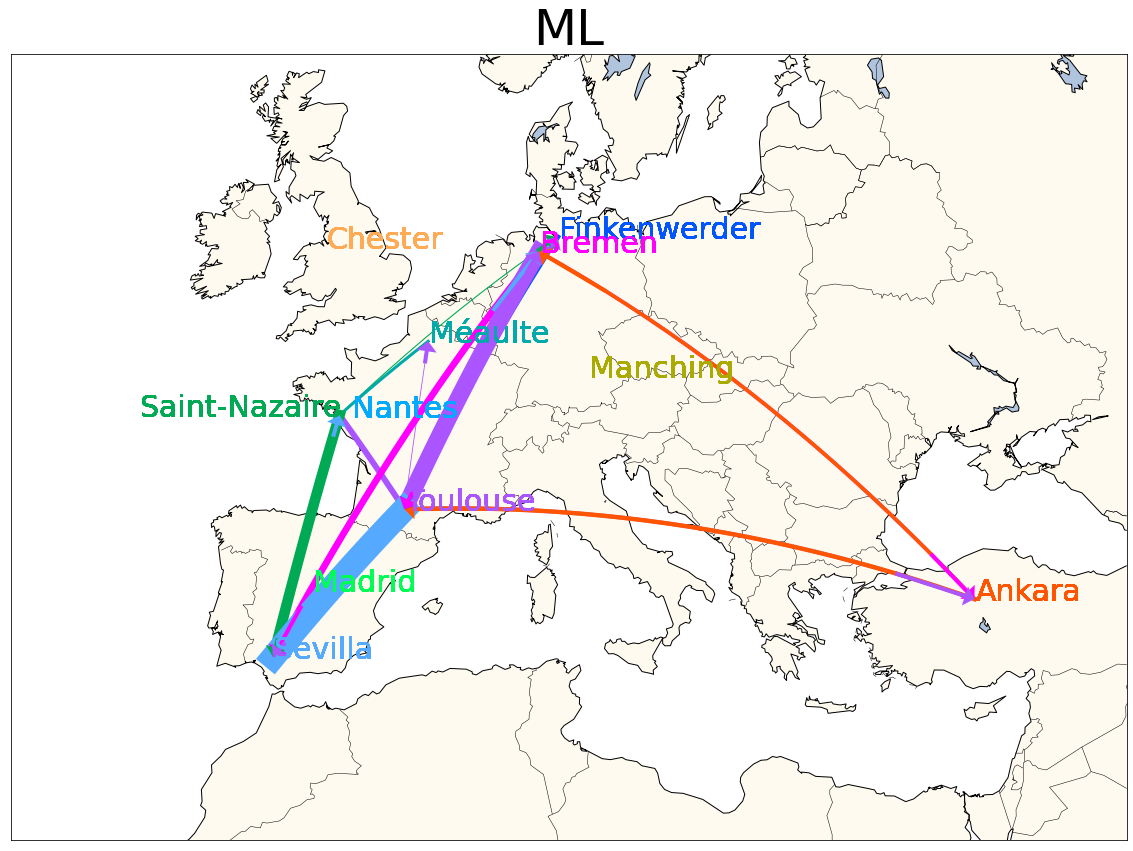

In [15]:
figure =plt.figure(figsize =(20,20))
fleches('ML')

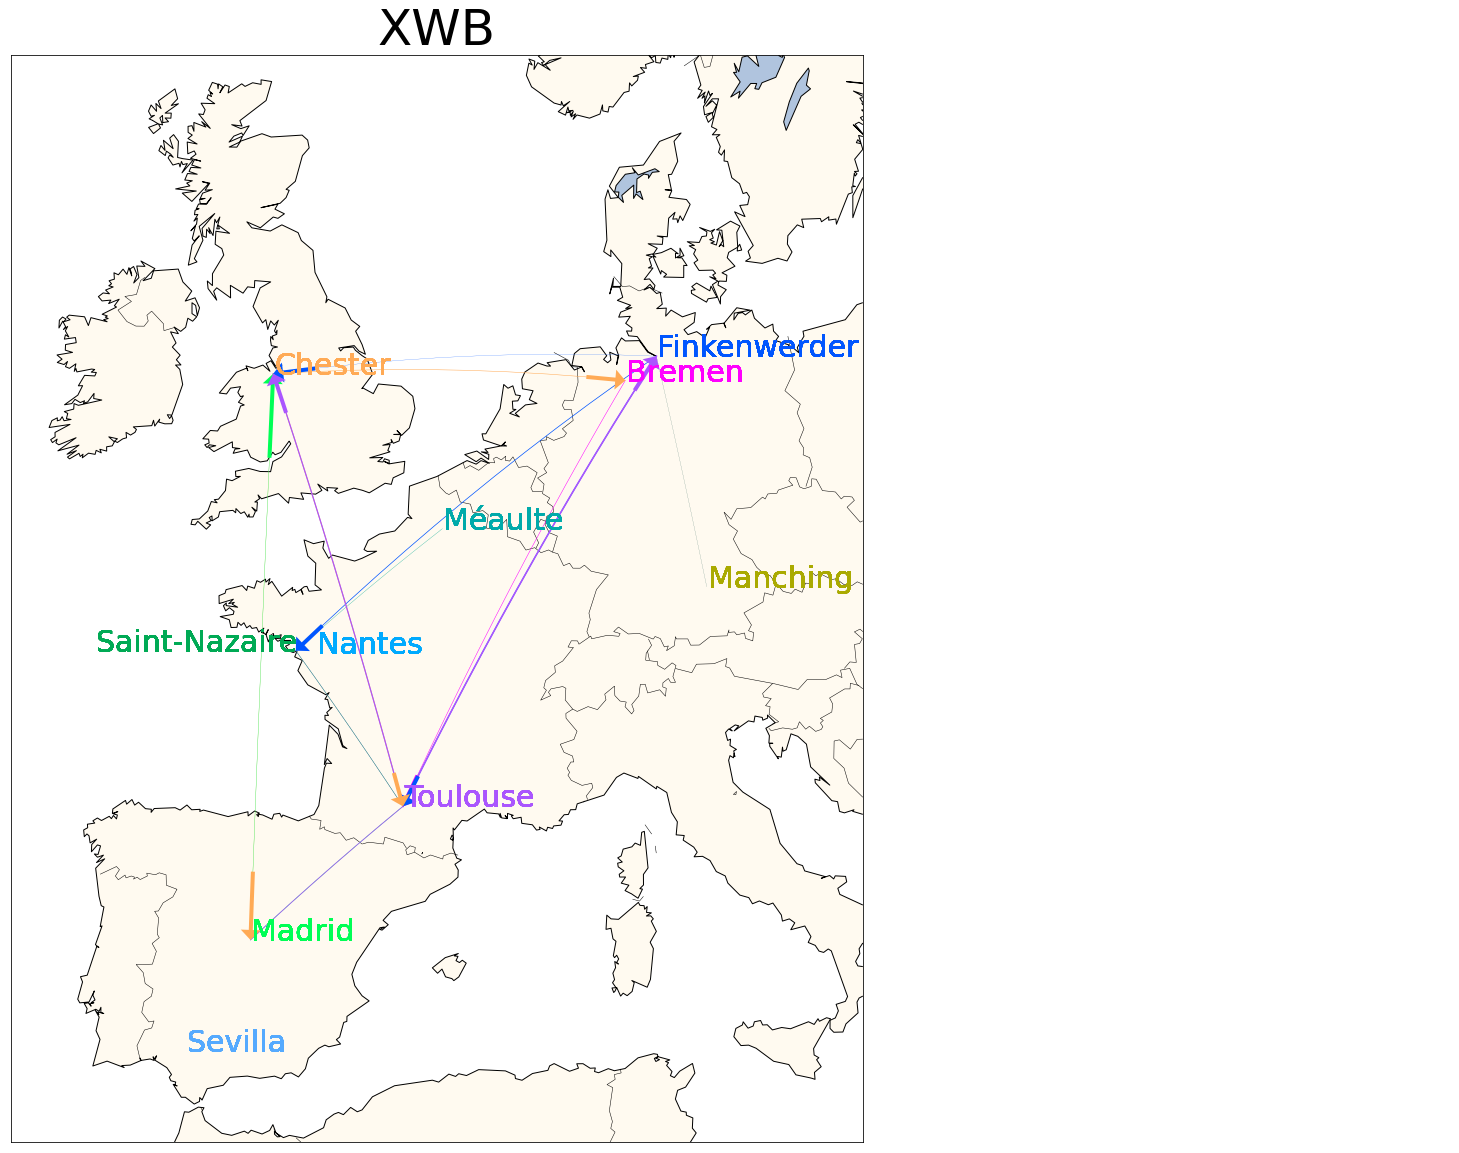

In [16]:
figure =plt.figure(figsize =(20,20))
fleches('XWB')

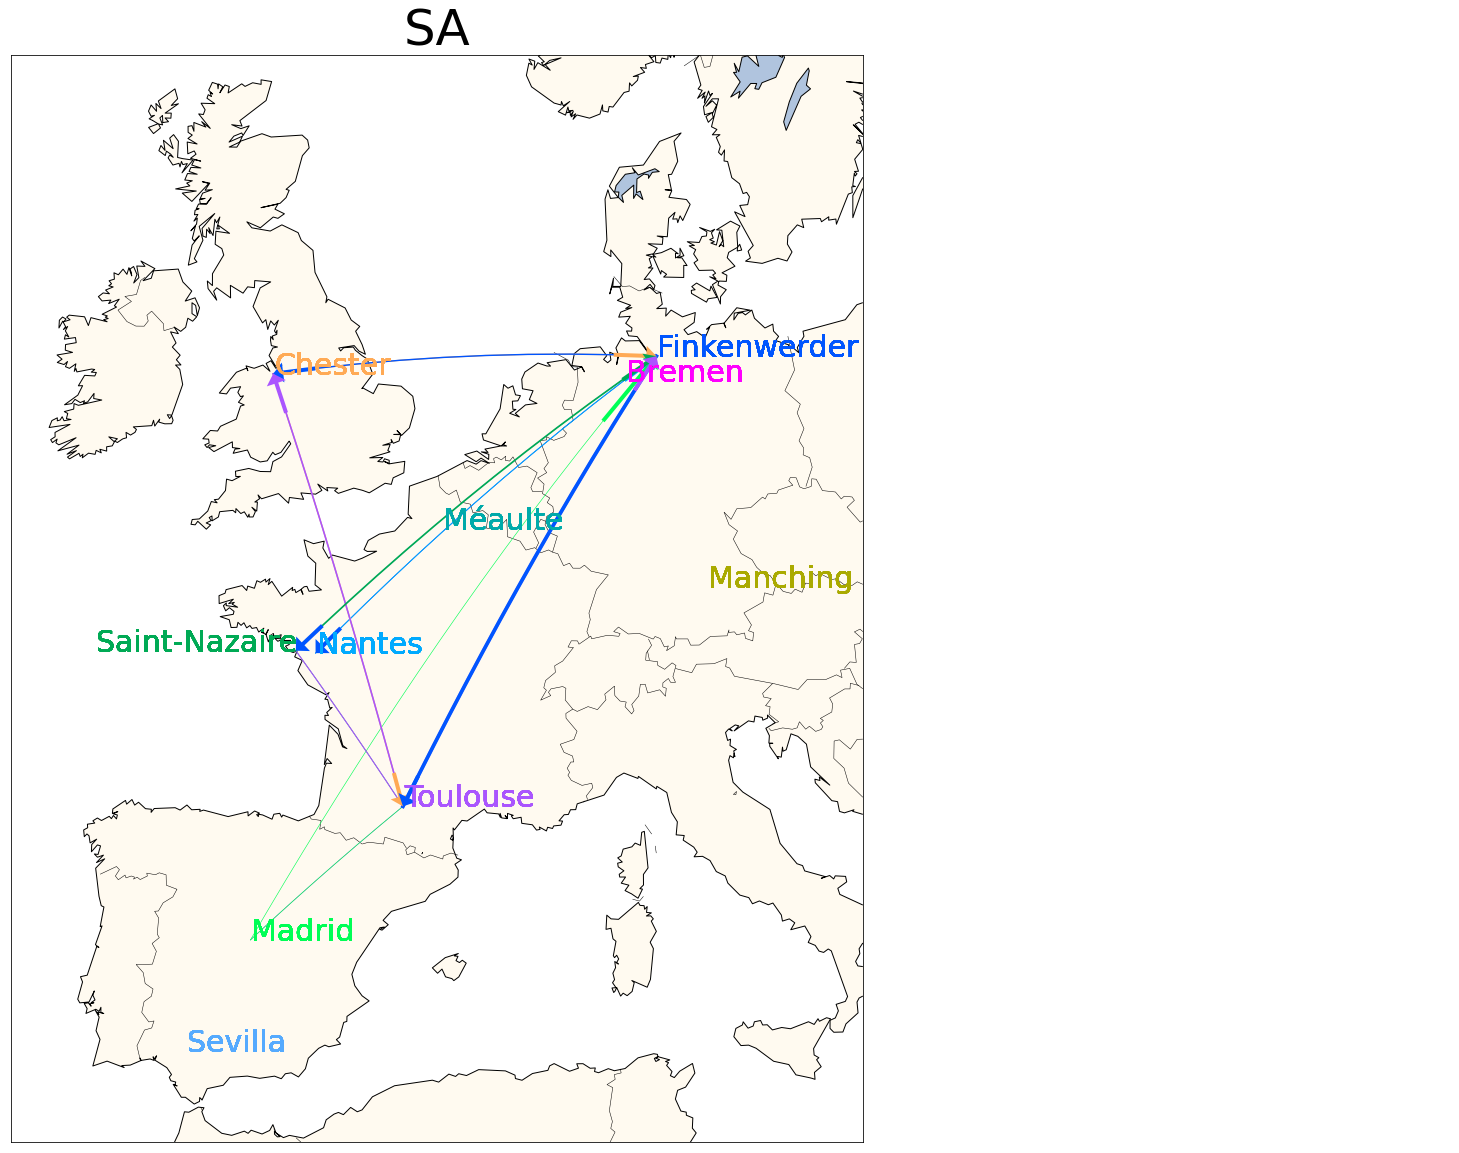

In [17]:
figure =plt.figure(figsize =(20,20))
fleches('SA')

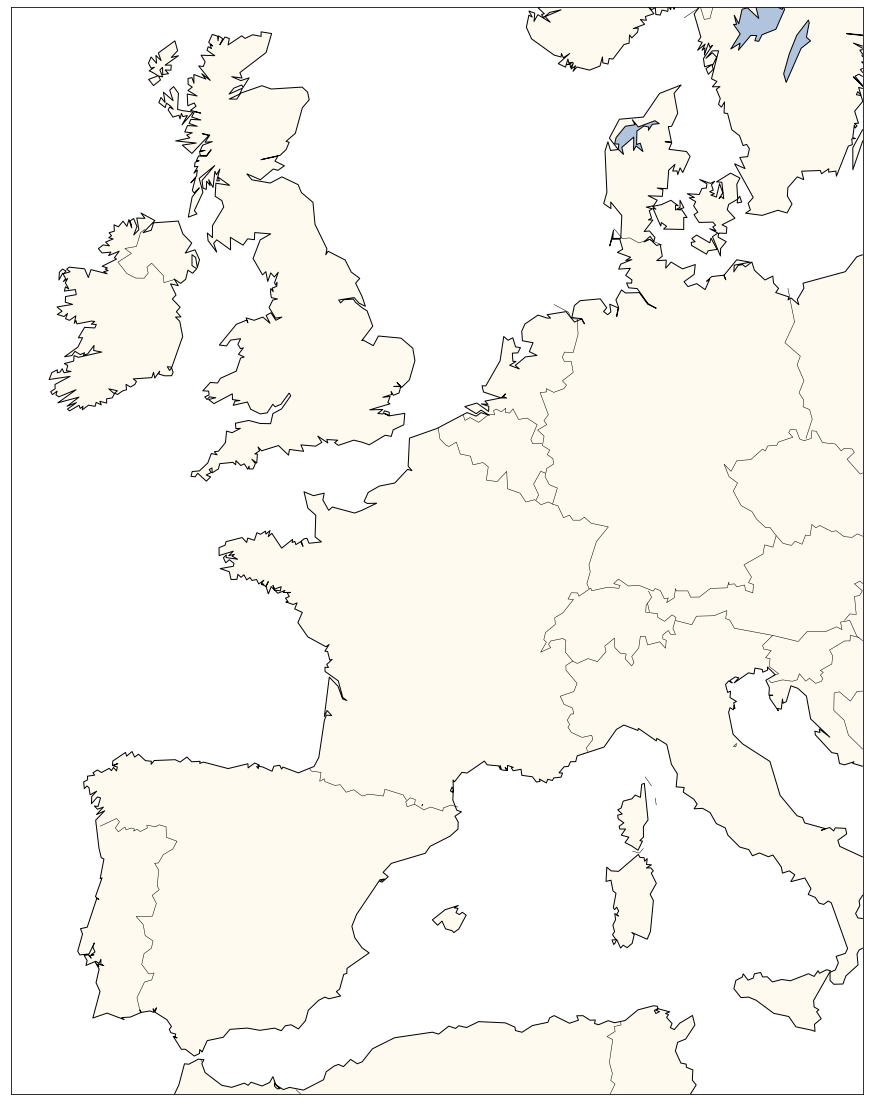

In [18]:
figure =plt.figure(figsize =(20,20))
fleches('LA')

**Report in a tabular form, number of total flight hours. **
 

In [19]:
def report(PROG) :
    REPORT=pd.DataFrame(columns=['Origin',
                                 'Destination',
                                 'Total_ST_XL_flight_hours'])
    tot=0
    for line in DBfinal.itertuples():
        if line.program !=PROG :
            continue
        else :
            REPORT=REPORT.append({'Origin':line.Name_x,'Destination':line.Name_y,
                                  'Total_ST_XL_flight_hours':float(round(line.ST_XL_flight_hours,1))},ignore_index=True)
            tot=tot+line.ST_XL_flight_hours
    
    REPORT=REPORT.append({'Origin':'TOTAL','Destination':"",'Total_ST_XL_flight_hours':float(round(tot,1))},ignore_index=True)
    return   REPORT       


In [20]:
ReportA330=report('LR')
print("A330")
print(tabulate(ReportA330, headers='keys', tablefmt='fancy_grid',floatfmt=".1f"))

A330
╒════╤═══════════════╤═══════════════╤════════════════════════════╕
│    │ Origin        │ Destination   │   Total_ST_XL_flight_hours │
╞════╪═══════════════╪═══════════════╪════════════════════════════╡
│  0 │ Saint-Nazaire │ Méaulte       │                        0.6 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  1 │ Méaulte       │ Saint-Nazaire │                        0.6 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  2 │ Madrid        │ Toulouse      │                        0.9 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  3 │ Toulouse      │ Madrid        │                        1.0 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  4 │ Toulouse      │ Saint-Nazaire │                        1.5 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  5 │ Finkenwerder  │ Saint-Nazaire │                        2.2 │
├────┼───────────────┼───────────────┼─────

In [21]:
ReportA400M=report('ML')
print("A400M")
print(tabulate(ReportA400M, headers='keys', tablefmt='fancy_grid',floatfmt=".1f"))

A400M
╒════╤═══════════════╤═══════════════╤════════════════════════════╕
│    │ Origin        │ Destination   │   Total_ST_XL_flight_hours │
╞════╪═══════════════╪═══════════════╪════════════════════════════╡
│  0 │ Saint-Nazaire │ Toulouse      │                        0.3 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  1 │ Saint-Nazaire │ Méaulte       │                        0.3 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  2 │ TOTAL         │               │                        0.6 │
╘════╧═══════════════╧═══════════════╧════════════════════════════╛


In [22]:
ReportA350=report('XWB')
print("A350")
print(tabulate(ReportA350, headers='keys', tablefmt='fancy_grid',floatfmt=".1f"))

A350
╒════╤═══════════════╤═══════════════╤════════════════════════════╕
│    │ Origin        │ Destination   │   Total_ST_XL_flight_hours │
╞════╪═══════════════╪═══════════════╪════════════════════════════╡
│  0 │ Madrid        │ Madrid        │                        0.0 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  1 │ Toulouse      │ Toulouse      │                        0.3 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  2 │ Saint-Nazaire │ Méaulte       │                        1.3 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  3 │ Finkenwerder  │ Manching      │                        1.3 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  4 │ Manching      │ Finkenwerder  │                        1.4 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  5 │ Méaulte       │ Saint-Nazaire │                        1.6 │
├────┼───────────────┼───────────────┼─────

In [23]:
ReportSA=report('SA')
print("Single Aisle")
print(tabulate(ReportSA, headers='keys', tablefmt='fancy_grid',floatfmt=".1f"))

Single Aisle
╒════╤═══════════════╤═══════════════╤════════════════════════════╕
│    │ Origin        │ Destination   │   Total_ST_XL_flight_hours │
╞════╪═══════════════╪═══════════════╪════════════════════════════╡
│  0 │ Madrid        │ Madrid        │                        0.4 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  1 │ Toulouse      │ Toulouse      │                        3.7 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  2 │ Finkenwerder  │ Saint-Nazaire │                        5.8 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  3 │ Toulouse      │ Madrid        │                        6.1 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  4 │ Madrid        │ Finkenwerder  │                        6.3 │
├────┼───────────────┼───────────────┼────────────────────────────┤
│  5 │ Madrid        │ Toulouse      │                        6.9 │
├────┼───────────────┼─────────────

In [24]:
ReportLA=report('LA')
print("A380")
print(tabulate(ReportLA, headers='keys', tablefmt='fancy_grid',floatfmt=".1f"))

A380
╒════╤══════════╤═══════════════╤════════════════════════════╕
│    │ Origin   │ Destination   │   Total_ST_XL_flight_hours │
╞════╪══════════╪═══════════════╪════════════════════════════╡
│  0 │ TOTAL    │               │                        0.0 │
╘════╧══════════╧═══════════════╧════════════════════════════╛
